<a href="https://colab.research.google.com/github/M1croZavr/rutube-recsys/blob/master/Video_recommendation_using_ALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=a00368f07839a5ce3f0054369a23175ee575ece5163809433ef588c182aa2f49
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import math
import os
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark.mllib.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc, col
from pyspark.sql.types import StringType, ArrayType

%matplotlib inline

In [ ]:
# spark config
spark= SparkSession \
       .builder \
       .appName("ALS recommender") \
       .getOrCreate()
# get spark context
sc = spark.sparkContext

In [ ]:
# path config
data_path = pathlib.Path('./drive/MyDrive/recsys/data/')

# Load Data

In [ ]:
!ls -la ./drive/MyDrive/recsys/data

total 6999868
-rw------- 1 root root    7591712 Feb 10 14:25 emotions.parquet
-rw------- 1 root root    9179744 May 10 14:01 player_10000_by_emotions.parquet
-rw------- 1 root root    9179744 Jun  1 10:28 player_10000u_84556i_by_emotions.parquet
-rw------- 1 root root   15693693 Jun 21 14:45 player_10265u_116030i_by_emotions.parquet
-rw------- 1 root root   20357637 Feb 19 20:02 player_11365.parquet
-rw------- 1 root root 2518550367 Feb 10 14:29 player_starts_train.parquet
-rw------- 1 root root    9862996 Jun  1 10:35 user_item_rating_118950i.csv
-rw------- 1 root root    2559002 Jun  1 10:35 user_item_rating_118950i.parquet
-rw------- 1 root root   19730890 Jun 21 14:51 user_item_rating_238107i.csv
-rw------- 1 root root    4890401 Jun 21 14:51 user_item_rating_238107i.parquet
-rw------- 1 root root    5459135 May 30 19:44 user_item_rating_61738i.csv
-rw------- 1 root root    1379146 May 30 19:44 user_item_rating_61738i.parquet
-rw------- 1 root root   13256179 May 10 18:15 user_item

In [ ]:
movies = spark.read.load(
    str(data_path) + '/videos.csv',
    format='csv',
    header=True,
    inferSchema=True
)
ratings = spark.read.load(
    str(data_path) + '/user_item_rating_238107i.csv',
    format='csv',
    header=True,
    inferSchema=True
).dropna(subset='rating')

## Basic inspection

In [ ]:
movies.show(3)

+-------------+--------------------+--------------------+--------+------+--------------------+--------------------+--------------------+--------+-----------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      item_id|         video_title|        author_title|tv_title|season|   video_description|      category_title|          publicated|duration|channel_sub|tv_sub|ctr.CTR_10days_01_09|ctr.CTR_10days_10_09|ctr.CTR_10days_20_09|ctr.CTR_10days_30_09|ctr.CTR_10days_01_10|ctr.CTR_10days_10_10|ctr.CTR_10days_20_10|ctr.CTR_10days_30_10|ctr.CTR_10days_01_11|ctr.CTR_10days_10_11|ctr.CTR_10days_20_11|ctr.CTR_10days_30_11|ctr.CTR_10days_01_12|ctr.CTR_10days_10_12|ctr.CTR_10days_20_12|ctr.CTR_10days_30_12

In [ ]:
ratings.show(3), ratings.count()

+-------------------+-------------+-------------+----------+--------------+-------------------+------------+------+
|     event_datetime|      user_id|      item_id|watch_time|video_duration|  feedback_datetime|        type|rating|
+-------------------+-------------+-------------+----------+--------------+-------------------+------------+------+
|2023-09-06 18:58:23|user_15133278|video_1134138|        -1|           387|2023-09-06 15:58:17|       v_top|     2|
|2023-09-06 05:12:49|user_29957940|video_1134138|         1|           387|2023-09-06 02:12:48|pos_emotions|     1|
|2023-09-07 19:00:16|user_18818653|video_1134138|         1|           387|2023-09-07 16:00:08|       v_top|     2|
+-------------------+-------------+-------------+----------+--------------+-------------------+------------+------+
only showing top 3 rows



(None, 238107)

What are the ratings?

In [ ]:
print('Distinct values of ratings:')
print(sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
[0.0, 1.0, 2.0]


What is minimum number of ratings per user and minimum number of ratings per movie?

In [ ]:
tmp1 = ratings.groupBy("user_id").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("item_id").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 1
Minimum number of ratings per movie is 1


How many movies are rated by only one user?

In [ ]:
tmp1 = sum(ratings.groupBy("item_id").count().toPandas()['count'] == 1)
tmp2 = ratings.select('item_id').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

19185 out of 26710 movies are rated by only one user


What is the total number of users in the data sets?

In [ ]:
tmp = ratings.select('user_id').distinct().count()
print('We have a total of {} distinct users in the data sets'.format(tmp))

We have a total of 9246 distinct users in the data sets


What is the total number of movies in the data sets?

In [ ]:
tmp = movies.select('item_id').distinct().count()
print('We have a total of {} distinct movies in the data sets'.format(tmp))

We have a total of 15542155 distinct movies in the data sets


How many movies are rated by users? List movies not rated yet?

In [ ]:
tmp1 = movies.select('item_id').distinct().count()
tmp2 = ratings.select('item_id').distinct().count()
print('We have a total of {} distinct movies that are rated by users in ratings table'.format(tmp2))
print('We have {} movies that are not rated yet'.format(tmp1 - tmp2))

We have a total of 26710 distinct movies that are rated by users in ratings table
We have 15515445 movies that are not rated yet


In [ ]:
# create a temp SQL table view for easier query
movies.createOrReplaceTempView("movies")
ratings.createOrReplaceTempView("ratings")
# print('List movies that are not rated yet: ')
# SQL query (NOTE: WHERE ... NOT IN ... == ... LEFT JOIN ... WHERE ... IS NULL)
# Approach 1
# spark.sql(
#     "SELECT item_id, video_title "
#     "FROM movies "
#     "WHERE item_id NOT IN (SELECT distinct(item_id) FROM ratings)"
# ).show(10)
# Approach 2
# spark.sql(
#     "SELECT m.movieId, m.title "
#     "FROM movies m LEFT JOIN ratings r ON m.movieId=r.movieId "
#     "WHERE r.movieId IS NULL"
# ).show(10)

In [ ]:
# movies_small = movies.join(ratings, movies.item_id == ratings.item_id, 'inner')
movies_small = spark.sql(
    "SELECT user_id, r.item_id, video_title AS title, event_datetime "
    "FROM ratings r "
    "INNER JOIN movies m ON r.item_id = m.item_id "
    "ORDER BY event_datetime ASC"
)

In [ ]:
movies_small.show(10)

+-------------+-------------+--------------------+-------------------+
|      user_id|      item_id|               title|     event_datetime|
+-------------+-------------+--------------------+-------------------+
| user_4329458|video_3442132|Сопрано S03E06 Ун...|2023-08-31 21:00:03|
| user_3576973|video_3131219|#видеомейкинг #ви...|2023-08-31 21:00:08|
| user_4161636|video_2173882|Первые высотки пр...|2023-08-31 21:00:18|
|user_25263908|video_2361603| Волк кушает бублики|2023-08-31 21:01:02|
|user_17492633|video_1682383|Рисунок поросенка...|2023-08-31 21:01:46|
|user_25663791|video_3481709|Балтика - Зенит. ...|2023-08-31 21:02:57|
|user_14081210|video_1338748|Не свети-ка месяц...|2023-08-31 21:03:24|
|user_12585573|video_2371248|МЫЩЦЫ ТАЗОВОГО ДН...|2023-08-31 21:03:52|
|   user_54537|video_1845511|Увлекательное вид...|2023-08-31 21:05:04|
| user_4161636| video_345406|  Мятная брюква #028|2023-08-31 21:05:30|
+-------------+-------------+--------------------+-------------------+
only s

In [ ]:
movies_small.count()

237742

In [ ]:
movies_small_df = movies_small.toPandas()
movies_small_df.to_csv('./drive/MyDrive/recsys/data/user_item_title_237742i.csv')

In [ ]:
movies_small_df.nunique()

user_id             9380
item_id            23353
title              23114
event_datetime    234706
dtype: int64

## Spark ALS based approach for training model
1. Reload data
2. Split data into train, validation, test
3. ALS model selection and evaluation
4. Model testing

### Reload data
We will use an RDD-based API from pyspark.mllib to predict the ratings, so let's reload "ratings.csv" using sc.textFile and then convert it to the form of (user, item, rating) tuples.

In [ ]:
# load data
movie_rating = sc.textFile(os.path.join(data_path, 'user_item_rating_9696.csv'))
# preprocess data -- only need ["user_id", "item_id", "rating"]
header = movie_rating.take(1)[0]
rating_data = movie_rating \
    .filter(lambda line: line != header) \
    .map(lambda line: line.split(",")) \
    .filter(lambda tokens: tokens[7] != '') \
    .map(lambda tokens: (tokens[1], tokens[2], float(tokens[7]))) \
    .cache()
# check three rows
rating_data.take(3), rating_data.count()

([('user_25263908', 'video_2597185', 2.0),
  ('user_1206280', 'video_908411', 2.0),
  ('user_17162325', 'video_2631795', 1.0)],
 87266)

### Split data
Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [ ]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=123)

In [ ]:
USER_ID_MAPER = dict()
ITEM_ID_MAPER = dict()

for line in rating_data.collect():
    user_id, item_id, rating = line
    if user_id not in USER_ID_MAPER:
        USER_ID_MAPER[user_id] = max(USER_ID_MAPER.values()) + 1 if USER_ID_MAPER else 0
    if item_id not in ITEM_ID_MAPER:
        ITEM_ID_MAPER[item_id] = max(ITEM_ID_MAPER.values()) + 1 if ITEM_ID_MAPER else 0

In [ ]:
train = train.map(
    lambda t: (
        USER_ID_MAPER[t[0]],
        ITEM_ID_MAPER[t[1]],
        t[2]
    )
)
validation = validation.map(
    lambda t: (
        USER_ID_MAPER[t[0]],
        ITEM_ID_MAPER[t[1]],
        t[2]
    )
)
test = test.map(
    lambda t: (
        USER_ID_MAPER[t[0]],
        ITEM_ID_MAPER[t[1]],
        t[2]
    )
)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[58] at RDD at PythonRDD.scala:53

### ALS model selection and evaluation
With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [ ]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (user_id, item_id, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=123
            )
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [ ]:
# hyper-param config
num_iterations = 10
ranks = [14]  # [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.1]  # [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

14 latent factors and regularization = 0.1: validation RMSE is 0.5480801892459494

The best model has 14 latent factors and regularization = 0.1
Total Runtime: 23.80 seconds


### ALS model learning curve
As we increase number of iterations in training ALS, we can see how RMSE changes and whether or not model is overfitted.

In [ ]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (user_id, product_id, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=123
        )
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

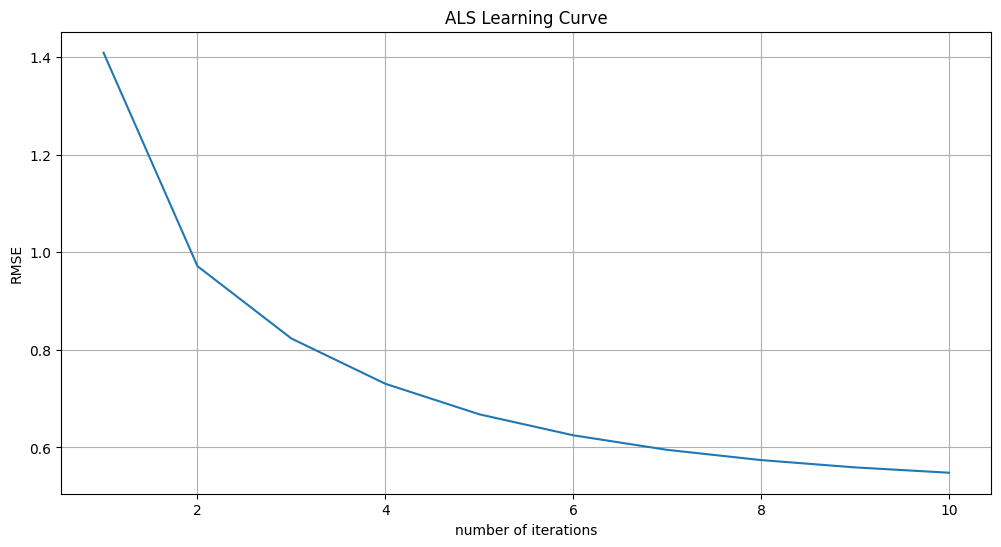

In [ ]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.1, 14)

After 3 iterations, alternating gradient descend starts to converge at an error around 0.8

### Model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [ ]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.55


### Make movie recommendation to myself
We need to define a function that takes new user's movie rating and output top 10 recommendations

In [ ]:
def get_movieId(df_movies, fav_movie_list):
    """
    return all movieId(s) of user's favorite movies

    Parameters
    ----------
    df_movies: spark Dataframe, movies data

    fav_movie_list: list, user's list of favorite movies

    Return
    ------
    movieId_list: list of movieId(s)
    """
    movieId_list = []
    for movie in fav_movie_list:
        movieIds = df_movies \
            .filter(movies.video_title.like('%{}%'.format(movie))) \
            .select('item_id') \
            .rdd \
            .map(lambda r: ITEM_ID_MAPER[r[0]]) \
            .collect()
        movieId_list.extend(movieIds)
    return list(set(movieId_list))


def add_new_user_to_data(train_data, movieId_list, spark_context):
    """
    add new rows with new user, user's movie and ratings to
    existing train data

    Parameters
    ----------
    train_data: spark RDD, ratings data

    movieId_list: list, list of movieId(s)

    spark_context: Spark Context object

    Return
    ------
    new train data with the new user's rows
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    # create new user rdd
    user_rows = [(new_id, movieId, max_rating) for movieId in movieId_list]
    new_rdd = spark_context.parallelize(user_rows)
    # return new train data
    return train_data.union(new_rdd)


def get_inference_data(train_data, df_movies, movieId_list):
    """
    return a rdd with the userid and all movies (except ones in movieId_list)

    Parameters
    ----------
    train_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data

    movieId_list: list, list of movieId(s)

    Return
    ------
    inference data: Spark RDD
    """
    # get new user id
    new_id = train_data.map(lambda r: USER_ID_MAPER[r[0]]).max() + 1
    # return inference rdd
    return df_movies.rdd \
        .map(lambda r: ITEM_ID_MAPER[r[0]]) \
        .distinct() \
        .filter(lambda x: x not in movieId_list) \
        .map(lambda x: (new_id, x))


def make_recommendation(best_model_params, ratings_data, df_movies,
                        fav_movie_list, n_recommendations, spark_context):
    """
    return top n movie recommendation based on user's input list of favorite movies


    Parameters
    ----------
    best_model_params: dict, {'iterations': iter, 'rank': rank, 'lambda_': reg}

    ratings_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data

    fav_movie_list: list, user's list of favorite movies

    n_recommendations: int, top n recommendations

    spark_context: Spark Context object

    Return
    ------
    list of top n movie recommendations
    """
    # modify train data by adding new user's rows
    movieId_list = get_movieId(df_movies, fav_movie_list)
    train_data = ratings_data.map(
        lambda t: (
            USER_ID_MAPER[t[0]],
            ITEM_ID_MAPER[t[1]],
            t[2]
        )
    )
    train_data = add_new_user_to_data(train_data, movieId_list, spark_context)

    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=123
    )

    # get inference rdd
    inference_rdd = get_inference_data(ratings_data, df_movies, movieId_list)

    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))

    # get top n movieId
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]

    # return movie titles
    return df_movies.filter(movies_small.item_id.isin(topn_ids)) \
                    .select('video_title') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

Let's pretend I am a new user in this recommender system. I will input a handful of my all-time favorite movies into the system. And then the system should output top N movie recommendations for me to watch

In [ ]:
movies_small.groupBy('video_title').count().sort(col('count').desc()).show(10)

+--------------------+-----+
|         video_title|count|
+--------------------+-----+
|       уличные танцы|   33|
|Пиратка World of ...|   29|
|          Мир танков|   22|
|Assassin's Creed:...|   14|
|          Мир Танков|   12|
|   Вопрос на засыпку|   12|
|          МИР ТАНКОВ|   11|
|Фортнайт рулетка ...|    8|
|"Дмитрий Goblin П...|    8|
|           GreedFall|    8|
+--------------------+-----+
only showing top 10 rows



In [ ]:
# my favorite movies
my_favorite_movies = ['уличные танцы', 'Мир танков']

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 14, 'lambda_': 0.1},
    ratings_data=rating_data,
    df_movies=movies_small,
    fav_movie_list=my_favorite_movies,
    n_recommendations=10,
    spark_context=sc
)

print('Recommendations for {}:'.format(my_favorite_movies[0]))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

Recommendations for уличные танцы:


This list of movie recommendations look completely different than the list from my previous **KNN** model recommender. Not only it recommends movies outside of years between 2007 and 2009 periods, but also recommends movies that were less known. So this can offer users some elements of suprise so that users won't get bored by getting the same popular movies all the time.

So this list of recommendations can be blended into the previous list of recommendations from **KNN** model recommender